In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt

In [28]:
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/moorim/무림페이퍼_15분사용전력_210401-220630.xlsx')
data.columns
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


In [29]:
data

,기준시각,직전 15분 사용전력
0,2021-04-01 00:00:00,7224.0
1,2021-04-01 00:15:00,7274.4
2,2021-04-01 00:30:00,7442.4
3,2021-04-01 00:45:00,7392.0
4,2021-04-01 01:00:00,7576.8
...,...,...
42761,2022-06-30 22:45:00,5628.0
42762,2022-06-30 23:00:00,5560.8
42763,2022-06-30 23:15:00,5493.6
42764,2022-06-30 23:30:00,5527.2


###       ACF 확인

In [ ]:
def acf_plot(data, N_LAGS, pval):
    from statsmodels.graphics.tsaplots import plot_acf
    
    auto = pd.Series(data.values)
    for i in range(0, N_LAGS+1):
        print(f"lag at {i}'s autocorrelation = ", round(auto.autocorr(lag=i),2))
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range (1, N_LAGS +1)]
        scatter['autocorrelation'] = [ auto.autocorr(lag=i) for i in range(1, N_LAGS +1)]

    fig = plot_acf(data, lags=N_LAGS, alpha=pval)
    plt.xlabel(f'Lag at k (0 to {N_LAGS})')
    plt.ylabel("lag at k's autocorrelation")
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors='red',linewidth=1, s=200, alpha = .5)
    plt.show()

acf_plot(data['직전 15분 사용전력'].diff(1), 10, 0.05)
# acf_plot(data['직전 15분 사용전력'].diff(5), 30, 0.05)


### feature 생성

In [30]:
#lag (Auto Regression) lag 1까지 생성
data['직전 15분 사용전력'] = data['직전 15분 사용전력'].shift(1)
data['l_2']= data['직전 15분 사용전력'].shift(1)
data['l_3']= data['직전 15분 사용전력'].shift(2)
data['l_4']= data['직전 15분 사용전력'].shift(3)
data['l_5']= data['직전 15분 사용전력'].shift(4)
# data['l_6']= data['직전 15분 사용전력'].shift(6)
# data['l_7']= data['직전 15분 사용전력'].shift(7)
# data['l_8']= data['직전 15분 사용전력'].shift(8)
# data['l_9']= data['직전 15분 사용전력'].shift(9)
# data['l_10']= data['직전 15분 사용전력'].shift(10)

In [31]:
#diff 1 차분(직전, 직직전의 차이)
data['d_2']=data['직전 15분 사용전력'].diff(1)
data['d_3']=data['직전 15분 사용전력'].diff(2)
data['d_4']=data['직전 15분 사용전력'].diff(3)
data['d_5']=data['직전 15분 사용전력'].diff(4)
data['d_6']=data['직전 15분 사용전력'].diff(5)#.shift(1)


In [32]:
data

,기준시각,직전 15분 사용전력,l_2,l_3,l_4,l_5,d_2,d_3,d_4,d_5,d_6
0,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN,NaN,NaN,NaN
3,2021-04-01 00:45:00,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4,NaN,NaN,NaN
4,2021-04-01 01:00:00,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6,168.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0,-33.6,0.0,-201.6
42762,2022-06-30 23:00:00,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6,-16.8,-50.4,-16.8
42763,2022-06-30 23:15:00,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0,-33.6,-84.0,-117.6
42764,2022-06-30 23:30:00,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4,-151.2,-100.8,-151.2


In [ ]:
# 결측 보강(interplation)
# data=data.fillna(method='bfill')
# data=data.dropna()
# data

In [33]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date,end_time): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)& (data_t['기준시각'] < end_time )] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-30','2022-06-30','2022-06-30 23:45:00')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))


train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:30:00 , 95


In [34]:
df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
# df_val.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_19328\4173171199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_19328\4173171199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)



#### Y Scaling(minmax)

In [160]:
from sklearn.preprocessing import MinMaxScaler
# Y
minmax_scaler=MinMaxScaler()
minmax_scaler.fit(np.array(df_train['y']).reshape(-1,1))
df_train['y']=minmax_scaler.transform(np.array(df_train['y']).reshape(-1,1))
# feature
minmax_scaler2=MinMaxScaler()
minmax_scaler2.fit(np.array(df_train['d_2']).reshape(-1,1))
df_train['d_2']=minmax_scaler2.transform(np.array(df_train['d_2']).reshape(-1,1))

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\1418040195.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\1418040195.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [161]:
df_train

,ds,y,d_2
0,2021-04-01 00:00:00,0.806517,NaN
1,2021-04-01 00:15:00,0.812627,NaN
2,2021-04-01 00:30:00,0.832994,0.766169
3,2021-04-01 00:45:00,0.826884,0.783582
4,2021-04-01 01:00:00,0.849287,0.751244
...,...,...,...
39689,2022-05-29 22:45:00,0.643585,0.741294
39690,2022-05-29 23:00:00,0.653768,0.761194
39691,2022-05-29 23:15:00,0.655804,0.771144
39692,2022-05-29 23:30:00,0.639511,0.761194


#### model

In [37]:
model_tune = NeuralProphet(
# n_lags=3,
# n_forecasts=3,
num_hidden_layers=2,
impute_missing= "True",
normalize="auto",
# changepoints_range=0.95,
# n_changepoints=5,
learning_rate=0.1,
d_hidden=8
)
# model_tune = model_tune.add_lagged_regressor(names='l_1',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_2',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_3',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_4',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_5',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_6',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_7',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_8',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_9',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_10',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_1',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='l_2',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='l_3',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='l_4',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='l_5',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='d_2',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_3',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_4',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_5',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_6',normalize='minmax')   #regularization=0.05



In [137]:
# from locale import normalize


# model=NeuralProphet(n_lag=7)
# model = model.add_future_regressor(name='l_1',normalize='minmax')
# model = model.add_future_regressor(name='l_2',normalize='minmax')
# model = model.add_future_regressor(name='l_3',normalize='minmax')
# model = model.add_future_regressor(name='l_4',normalize='minmax')
# model = model.add_future_regressor(name='l_5',normalize='minmax')
# model = model.add_future_regressor(name='l_6',normalize='minmax')
# model = model.add_future_regressor(name='l_7',normalize='minmax')

In [38]:
#학습데이터, 검증데이터 분리
train, val = model_tune.split_df(df_train, valid_p = 0.1)
print(len(train),len(val))
train


INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 15T
INFO - (NP.forecaster.__handle_missing_data) - dropped 1 NAN row in 'y'
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(

INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values in column l_2 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column l_3 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN v

38403 4266


,ds,y,l_2,l_3,l_4,l_5,d_2,d_3,d_4,d_5,d_6
0,2021-04-01 00:15:00,7224.0,7224.0,7224.0,7224.0,7224.0,50.4,218.4,168.0,352.8,268.8
1,2021-04-01 00:30:00,7274.4,7224.0,7224.0,7224.0,7224.0,50.4,218.4,168.0,352.8,268.8
2,2021-04-01 00:45:00,7442.4,7274.4,7224.0,7224.0,7224.0,168.0,218.4,168.0,352.8,268.8
3,2021-04-01 01:00:00,7392.0,7442.4,7274.4,7224.0,7224.0,-50.4,117.6,168.0,352.8,268.8
4,2021-04-01 01:15:00,7576.8,7392.0,7442.4,7274.4,7224.0,184.8,134.4,302.4,352.8,268.8
...,...,...,...,...,...,...,...,...,...,...,...
38398,2022-05-16 12:15:00,6232.8,5997.6,5896.8,6048.0,6115.2,235.2,336.0,184.8,117.6,33.6
38399,2022-05-16 12:30:00,6098.4,6232.8,5997.6,5896.8,6048.0,-134.4,100.8,201.6,50.4,-16.8
38400,2022-05-16 12:45:00,6064.8,6098.4,6232.8,5997.6,5896.8,-33.6,-168.0,67.2,168.0,16.8
38401,2022-05-16 13:00:00,6232.8,6064.8,6098.4,6232.8,5997.6,168.0,134.4,0.0,235.2,336.0


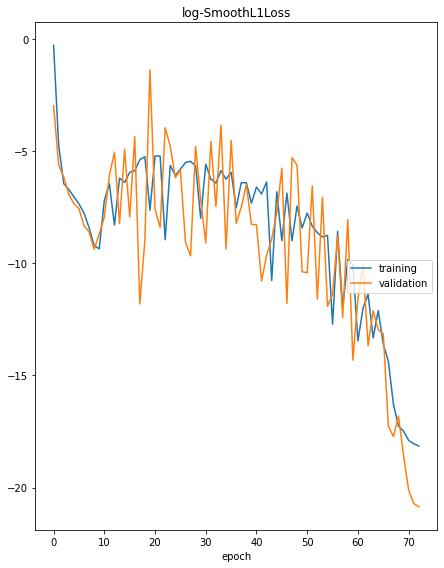

log-SmoothL1Loss
	training         	 (min:  -18.143, max:   -0.293, cur:  -18.143)
	validation       	 (min:  -20.849, max:   -1.378, cur:  -20.849)


In [39]:
from enum import auto
# model_tune = model_tune.highlight_nth_step_ahead_of_each_forecast(model_tune.n_forecasts)
metrics = model_tune.fit(train,validation_df=val,progress='plot')    #,freq='6H')

In [40]:
#metric 확인
print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(val): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  1.3206633748515716e-08
MAE(Train):  0.29663908099475056
MAE(val):  0.24585038181822233


In [171]:
# #loss 그래프
# import plotly.express as px
# px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

In [ ]:
# df_test=df_test.drop(['y'],axis=1)
# Y
# minmax_scaler=MinMaxScaler()
# minmax_scaler.fit(np.array(df_train['y']).reshape(-1,1))
# df_test['y']=minmax_scaler.transform(np.array(df_test['y']).reshape(-1,1))
# # feature
# minmax_scaler2=MinMaxScaler()
# minmax_scaler2.fit(np.array(df_train['d_2']).reshape(-1,1))
# df_test['d_2']=minmax_scaler2.transform(np.array(df_test['d_2']).reshape(-1,1))
# df_test

In [41]:
future_regressors_df = pd.DataFrame(data={ 'l_2': df_train['l_2'],'l_3': df_train['l_3'],'l_4': df_train['l_4'],'l_5': df_train['l_5'],'d_2': df_train['d_2'],'d_3': df_train['d_3'],'d_4': df_train['d_4'],'d_5': df_train['d_5'],'d_6': df_train['d_6']})

In [42]:
# future = model_tune.make_future_dataframe(df=df_train,periods=4*24)

future =  model_tune.make_future_dataframe(df=df_train, regressors_df=future_regressors_df ,periods=96, n_historic_predictions=True)
future

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)



,ds,y,l_2,l_3,l_4,l_5,d_2,d_3,d_4,d_5,d_6
0,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN,NaN,NaN,NaN
3,2021-04-01 00:45:00,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4,NaN,NaN,NaN
4,2021-04-01 01:00:00,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6,168.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,None,7492.8,7442.4,7509.6,7711.2,-184.8,-134.4,-201.6,-403.2,-268.8
42762,2022-06-30 23:00:00,None,7308.0,7492.8,7442.4,7509.6,117.6,-67.2,-16.8,-84.0,-285.6
42763,2022-06-30 23:15:00,None,7425.6,7308.0,7492.8,7442.4,100.8,218.4,33.6,84.0,16.8
42764,2022-06-30 23:30:00,None,7526.4,7425.6,7308.0,7492.8,-33.6,67.2,184.8,0.0,50.4


INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(

INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column l_2 were auto-imputed.
INFO - (NP.forecaster._

Text(0.5, 1.0, 'moorim_demand')

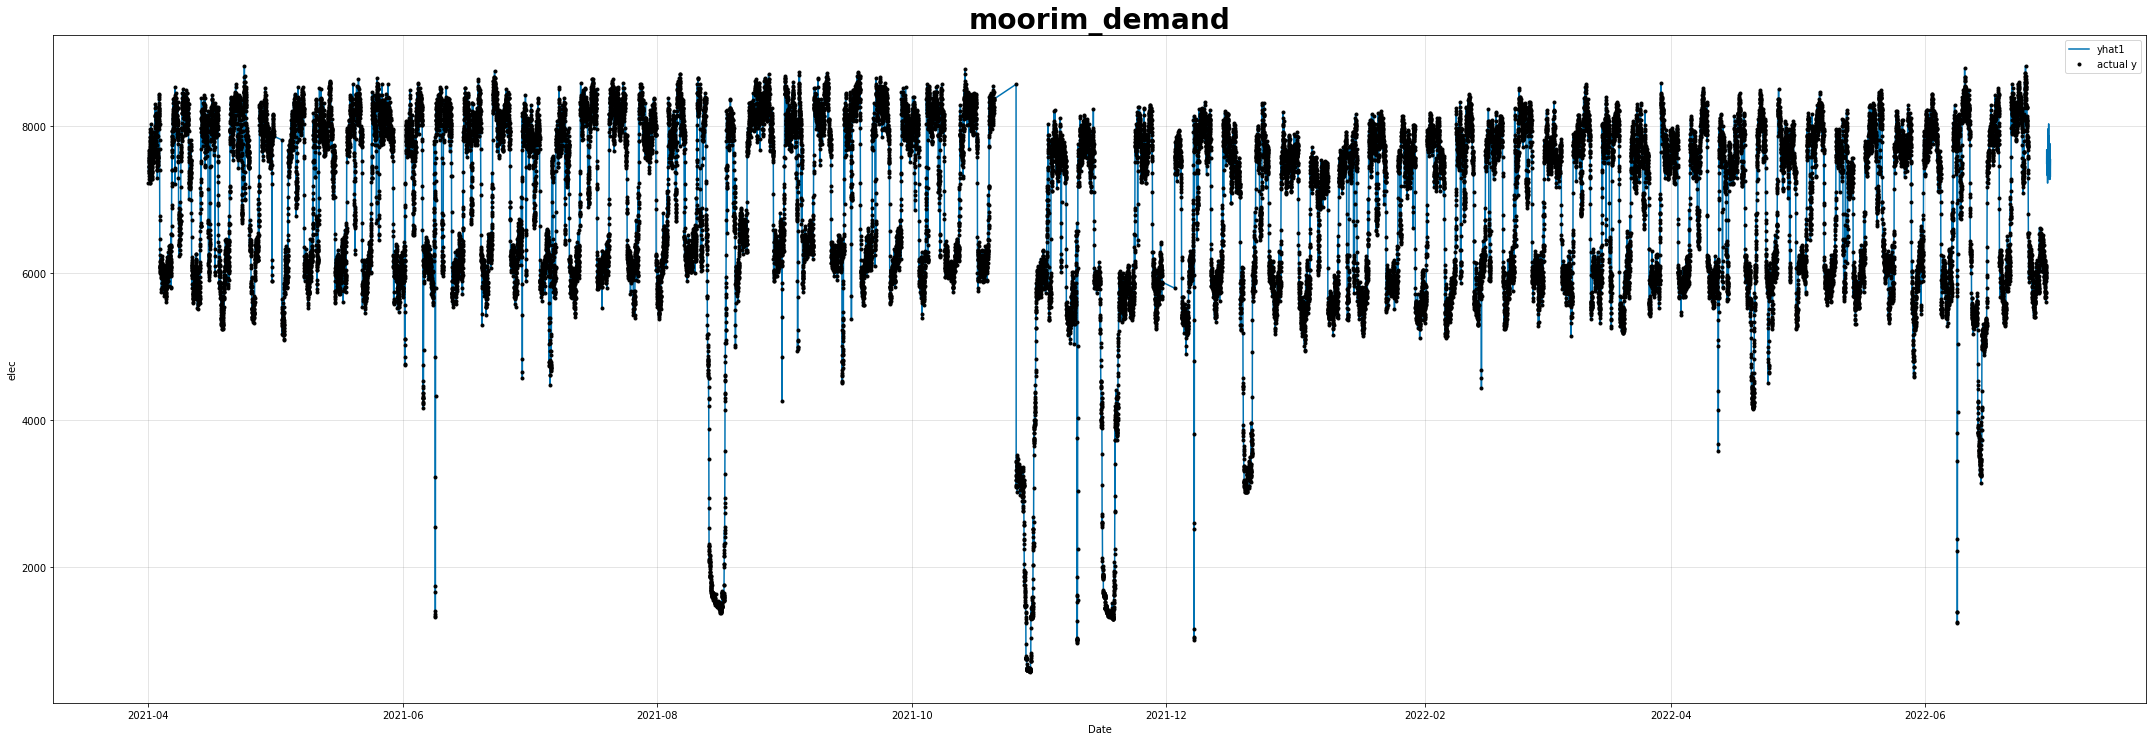

In [43]:
forecast = model_tune.predict(future)
# fig=model_tune.plot(forecast[['ds','y','yhat1']])


fig, ax = plt.subplots(figsize=(30, 10)) 
# model_tune.highlight_nth_step_ahead_of_each_forecast(model_tune.n_forecasts)
model_tune.plot(forecast, xlabel="Date", ylabel="elec", ax=ax)
ax.set_title("moorim_demand", fontsize=28, fontweight="bold")


In [121]:
forecast


,ds,y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_2,future_regressor_d_3,future_regressor_d_4,future_regressor_d_5,future_regressor_d_6,future_regressor_l_1,future_regressor_l_2,future_regressor_l_3,future_regressor_l_4,future_regressor_l_5
0,2021-04-01 00:00:00,7224.0,7410.162109,186.162109,-5120.324707,-0.107951,-0.292739,12530.887695,1415.509277,1494.984497,1192.212280,911.635254,864.071472,1848.989136,1835.914551,1257.874023,879.435791,830.262268
1,2021-04-01 00:15:00,7274.4,7410.169922,135.769922,-5120.324707,-0.108376,-0.285301,12530.887695,1415.509277,1494.984497,1192.212280,911.635254,864.071472,1848.989136,1835.914551,1257.874023,879.435791,830.262268
2,2021-04-01 00:30:00,7442.4,7456.372070,13.97207,-5120.324707,-0.108733,-0.260166,12577.066406,1447.680054,1494.984497,1192.212280,911.635254,864.071472,1862.996704,1835.914551,1257.874023,879.435791,830.262268
3,2021-04-01 00:45:00,7392.0,7429.148926,37.148926,-5120.324707,-0.109021,-0.219739,12549.802734,1387.934448,1466.865723,1192.212280,911.635254,864.071472,1909.688232,1849.822998,1257.874023,879.435791,830.262268
4,2021-04-01 01:00:00,7576.8,7565.277832,-11.522168,-5120.324707,-0.109240,-0.167963,12685.879883,1452.275757,1471.552124,1217.377686,911.635254,864.071472,1895.680786,1896.184448,1267.403564,879.435791,830.262268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,None,7424.868164,NaN,-5120.316895,0.052839,-0.104322,12545.237305,1433.892700,1415.314453,1157.609863,853.540894,795.029419,1872.335083,1910.092896,1299.167847,917.189392,891.064270
42762,2022-06-30 23:00:00,None,7526.502441,NaN,-5120.316895,0.055049,-0.160530,12646.924805,1429.296753,1494.984497,1167.046875,875.884888,832.688782,1905.019165,1859.095337,1308.697266,908.306213,865.904785
42763,2022-06-30 23:15:00,None,7492.634277,NaN,-5120.316895,0.057222,-0.212139,12613.106445,1392.530396,1452.806152,1195.357910,864.712830,836.873108,1933.034180,1891.548340,1273.756470,914.968628,857.518250
42764,2022-06-30 23:30:00,None,7542.787109,NaN,-5120.316895,0.059356,-0.254029,12663.298828,1415.509277,1438.746826,1182.775269,895.994507,836.873108,1923.695801,1919.365234,1295.991455,890.539856,863.808228


In [44]:
result_df=pd.merge(df_test[['ds','y']],forecast,how='left',on='ds')


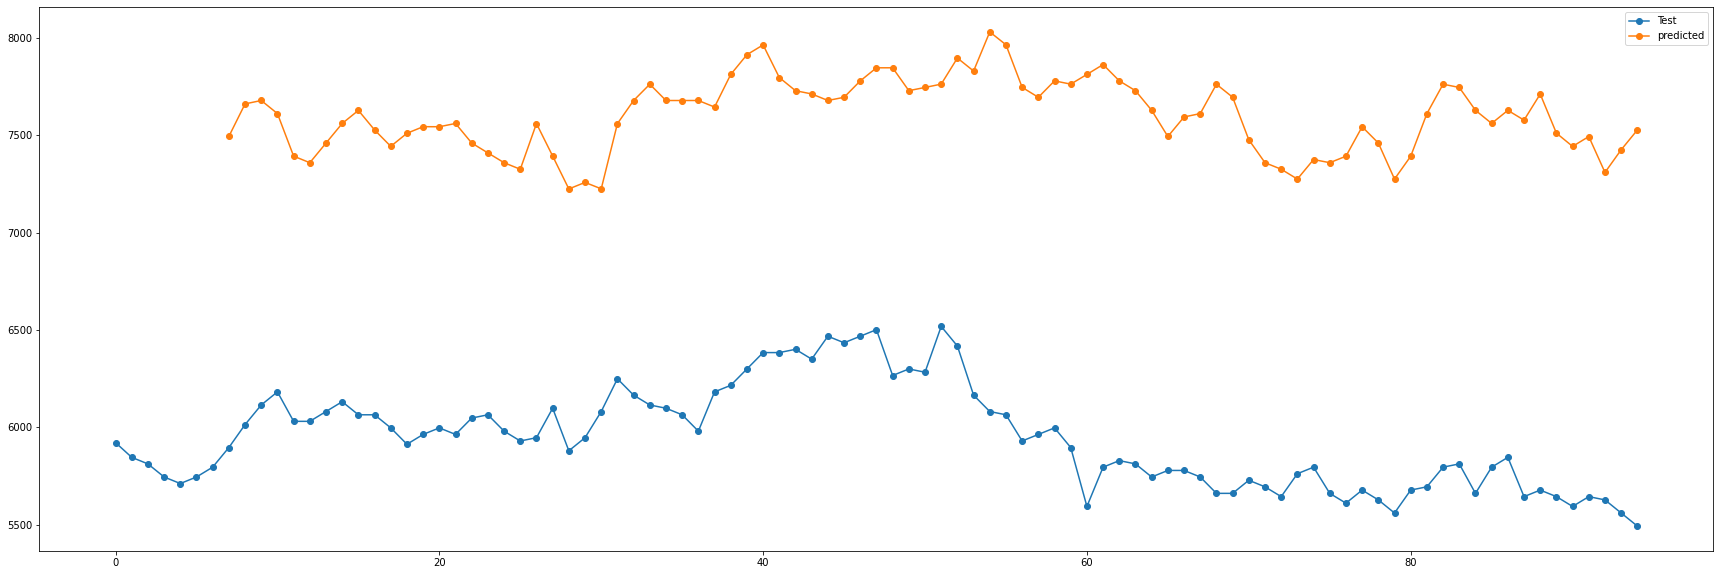

In [47]:
def predict_graph(test,prediction) : #train,
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)   
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(result_df['y_x'],result_df['yhat1'].shift(1))

In [214]:
# import numpy as np
# def SMAPE(y_true, y_pred):
#     return np.mean( (np.abs(y_true-y_pred)) / ((np.abs(y_true) + np.abs(y_pred))/2) ) * 100
# SMAPE(forecast['y'],forecast['yhat1'])

4.231247373783391

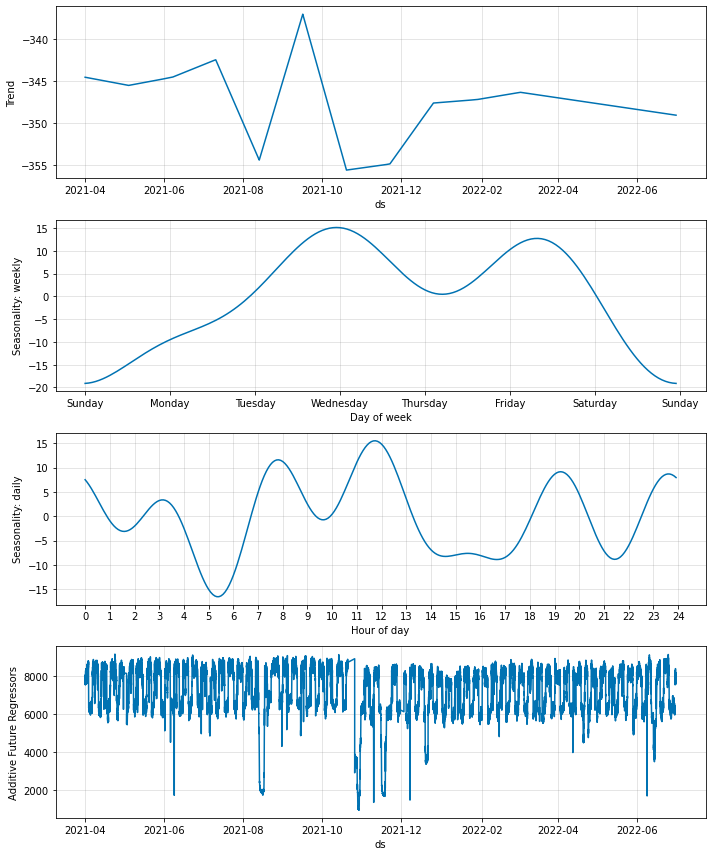

In [64]:
fig_comp = model_tune.plot_components(forecast)

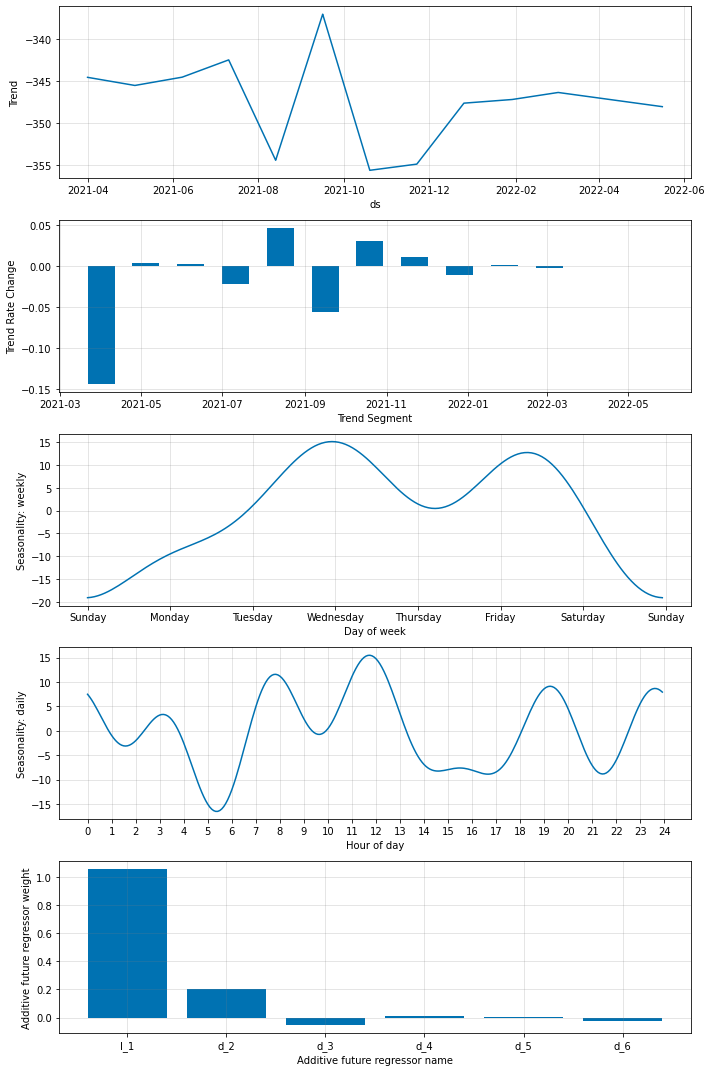

In [66]:
fig_param = model_tune.plot_parameters()

In [ ]:
# future = model.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
# forecast = model.predict(future)

### daily average


In [99]:
data=pd.read_csv('C:/Users/USER/Desktop/진행중/FEMS/datamart/(하루평균)무림페이퍼_15분사용전력_210401-220630.csv')
data=data[['date','평균(직전 15분 사용전력)']]

data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             447 non-null    datetime64[ns]
 1   평균(직전 15분 사용전력)  447 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [103]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['date'] < train_cut_date ]
    # df_val= data_t[(data_t['date'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['date'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-05-25','2022-05-25')
print('train_df=',min(df_train['date']),'~',max(df_train['date']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['date']),'~',max(df_test['date']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-05-24 00:00:00 , 410
test_df= 2022-05-25 00:00:00 ~ 2022-06-30 00:00:00 , 37


In [104]:

df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)
df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)



In [141]:
future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.297% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The fram

,ds,y,yhat1,residual1,trend
0,2022-05-25,7864.675,6834.283203,-1030.391797,6834.283203
1,2022-05-26,7697.2,6834.283203,-862.916797,6834.283203
2,2022-05-27,7769.825,6834.283203,-935.541797,6834.283203
3,2022-05-28,7064.8375,6834.283203,-230.554297,6834.283203
4,2022-05-29,5390.0875,6834.283203,1444.195703,6834.283203
...,...,...,...,...,...
69,2022-08-02,None,6834.283203,NaN,6834.283203
70,2022-08-03,None,6834.283203,NaN,6834.283203
71,2022-08-04,None,6834.283203,NaN,6834.283203
72,2022-08-05,None,6834.283203,NaN,6834.283203


Text(0.5, 1.0, 'demand')

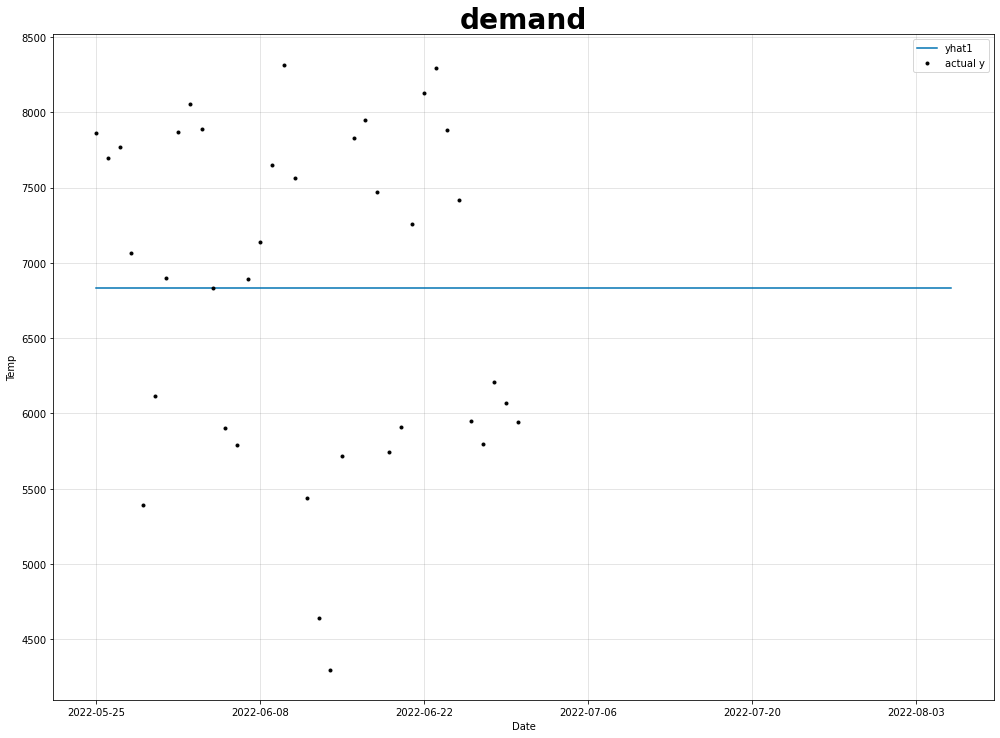

In [142]:
fig, ax = plt.subplots(figsize=(14, 10)) 
m.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
ax.set_title("demand", fontsize=28, fontweight="bold")